In [1]:
#import sys
#sys.path.append('/home/itsara/env/lib/python2.7/site-packages')

import numpy as np
import pandas as pd
import math
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt2
from keras.callbacks import ModelCheckpoint
import h5py

from keras.models import load_model

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume','close'], 1, inplace=True)
df.head()

,symbol,open,low,high,mv close
date,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,114.970001


In [3]:
symbols = list(set(df.symbol))
symbols[:5]

['JEC', 'WYNN', 'KMI', 'AN', 'FL']

In [4]:
SYM = 'FMC'
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,28.274999,27.934999,28.444999,28.410000
2010-01-05,28.450001,28.045000,28.495001,28.315001
2010-01-06,28.340000,28.155000,28.815001,28.590000
2010-01-07,28.540001,28.129999,28.729999,28.235001
2010-01-08,28.125000,27.600001,28.264999,27.985001


In [5]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
#    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['mv close'] = min_max_scaler.fit_transform(df['mv close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,0.046914,0.045661,0.038382,0.052166
2010-01-05,0.049910,0.047623,0.039248,0.050520
2010-01-06,0.048027,0.049585,0.044793,0.055286
2010-01-07,0.051451,0.049139,0.043320,0.049133
2010-01-08,0.044346,0.039686,0.035263,0.044801


In [6]:
def load_data(stock, seq_len):
    n_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]

    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))  

    return [x_train, y_train, x_test, y_test]

In [7]:
n_features = 4
prev_days = 4
X_train, y_train, X_test, y_test = load_data(df, prev_days)
print (X_train[0], y_train[0])

[[0.04691378 0.04566128 0.03838156 0.05216639]
 [0.04991013 0.04762329 0.03924799 0.05051995]
 [0.04802671 0.04958531 0.04479295 0.05528597]
 [0.05145109 0.04913937 0.04332005 0.04913347]] 0.04480071173658701


In [8]:
def build_model(layers):
    p = 0.25
    model = Sequential()

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(p))

    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(64,activation='relu'))
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

    return model

model = build_model([n_features, prev_days, 1])

In [9]:
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='auto')

model.fit(X_train, y_train, batch_size = 64, epochs = 50, validation_split = 0.05, verbose=1, callbacks=[checkpoint])

model.load_weights("weights.best.hdf5")
model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

Train on 1501 samples, validate on 80 samples
Epoch 1/50
1501/1501 [==============================] - 1s 915us/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 9.0684e-04 - val_mean_squared_error: 9.0684e-04

Epoch 00001: val_mean_squared_error improved from inf to 0.00091, saving model to weights.best.hdf5
Epoch 2/50
1501/1501 [==============================] - 0s 234us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 5.9089e-04 - val_mean_squared_error: 5.9089e-04

Epoch 00002: val_mean_squared_error improved from 0.00091 to 0.00059, saving model to weights.best.hdf5
Epoch 3/50
1501/1501 [==============================] - 0s 255us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 5.9356e-04 - val_mean_squared_error: 5.9356e-04

Epoch 00003: val_mean_squared_error did not improve
Epoch 4/50
1501/1501 [==============================] - 0s 270us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 6.0251e-04 - val_mean_squared_error: 6.0251e-04

1501/1501 [==============================] - 0s 266us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.3778e-04 - val_mean_squared_error: 6.3778e-04

Epoch 00036: val_mean_squared_error did not improve
Epoch 37/50
1501/1501 [==============================] - 0s 239us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 6.7510e-04 - val_mean_squared_error: 6.7510e-04

Epoch 00037: val_mean_squared_error did not improve
Epoch 38/50
1501/1501 [==============================] - 0s 310us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.5476e-04 - val_mean_squared_error: 6.5476e-04

Epoch 00038: val_mean_squared_error did not improve
Epoch 39/50
1501/1501 [==============================] - 0s 240us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 5.8985e-04 - val_mean_squared_error: 5.8985e-04

Epoch 00039: val_mean_squared_error did not improve
Epoch 40/50
1501/1501 [==============================] - 0s 253us/step - loss: 0.0013 - mean_squared

In [10]:
diff=[]
ratio=[]
predict = model.predict(X_test)
for d in range(len(y_test)):
    pred = predict[d][0]
    ratio.append((y_test[d]/pred)-1)
    diff.append(abs(y_test[d]- pred))

In [11]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume', 'close'], 1, inplace=True)
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['mv close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    _ = min_max_scaler.fit_transform(df)
    denorm = min_max_scaler.inverse_transform(normalized_value)
    return denorm

new_pred = denormalize(df, predict)
newy_test = denormalize(df, y_test)

In [12]:
def evaluation(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('MSE: %.5f (RMSE: %.2f)' % (score[0], math.sqrt(score[0])))
    return score[0], math.sqrt(score[0])

evaluation(model, X_test, y_test)

MSE: 0.00097 (RMSE: 0.03)


(0.0009742363789965483, 0.03121275987471387)

Sell [42.669998]
Balance: [100000.]
Sell [47.540001]
Balance: [100000.]
Buy [47.]
Buy [46.990002]
Buy [46.]
Buy [47.]
Buy [47.150002]
Buy [45.639999]
Buy [45.709999]
Buy [46.5]
Buy [47.439999]
Buy [47.330002]
Sell [48.380001]
Balance: [25917.51614678]
Sell [47.849998]
Balance: [45142.70842905]
Sell [48.119999]
Balance: [59642.96347709]
Sell [47.490002]
Balance: [70375.77450487]
Sell [47.689999]
Balance: [78459.28249011]
Buy [48.009998]
Buy [48.849998]
Sell [49.73]
Balance: [69915.85102155]
Sell [50.450001]
Balance: [78632.68030771]
Sell [50.349998]
Balance: [85157.34326744]
Sell [49.66]
Balance: [89983.77984317]
Sell [48.389999]
Balance: [93511.03408814]
Buy [48.139999]
Buy [48.580002]
Buy [49.]
Buy [48.290001]
Buy [48.619999]
Sell [48.23]
Balance: [58571.94462691]
Buy [48.73]
Sell [49.299999]
Balance: [62647.46882383]
Sell [45.119999]
Balance: [72309.04565809]
Buy [42.209999]
Buy [43.759998]
Buy [45.349998]
Buy [46.310001]
Buy [46.060001]
Sell [44.700001]
Balance: [41992.393362]
Sell 

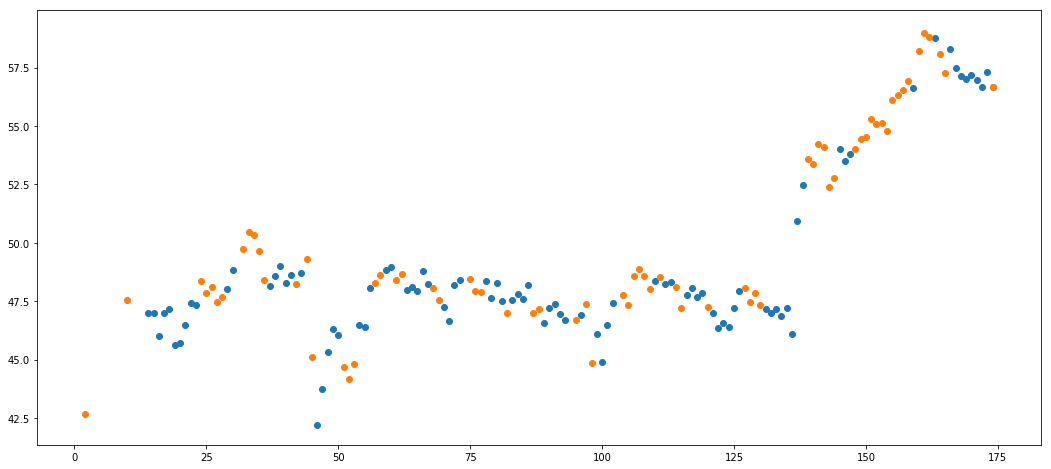

In [16]:
import random
random.seed(1997)

balance = 100000.0
cash_list= []
volume = 0
buyx = []
buyy =[]
selx = []
sely = []
for i in range(2,len(new_pred) - 1):
    prediction = new_pred[i]
    rand = random.randint(1, 100)
    if (prediction < new_pred[i-1] and balance != 0) or rand <= 5:
        if balance <= 10000:
            money = balance
            balance = 0
        else:
            money = 10000
            balance = balance - 10000
        volume += money / newy_test[i]
        buyx.append(i)
        buyy.append(newy_test[i])
        print("Buy " + str(newy_test[i]))
    elif(volume > 0 and prediction > new_pred[i-1] and prediction * 1.002 > new_pred[i-2]) or rand > 95:
        forSell = volume/4.0
        volume = volume*3.0/4.0
        balance += forSell * newy_test[i]
        selx.append(i)
        sely.append(newy_test[i])
        print("Sell " + str(newy_test[i]))
        print("Balance: " + str(balance))

if(volume != 0):
    balance += volume * newy_test[i]
    volume = 0
    selx.append(i)
    sely.append(newy_test[i])
    print("Sell : " + str(newy_test[i]))
    print("Balance : " + str(balance))
    
print("Balance : " + str(balance))
plt2.figure(figsize=(18,8))
plt2.scatter(buyx, buyy)
plt2.scatter(selx, sely)

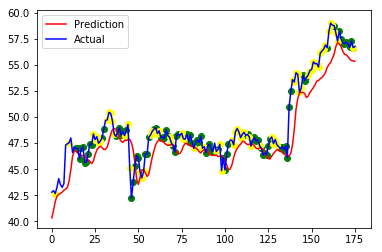

In [17]:
plt2.plot(new_pred,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.scatter(buyx, buyy, color='green')
plt2.scatter(selx, sely, color='yellow')
plt2.show()